In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

In [11]:
# Read Files
train = pd.read_csv("/Volumes/Programming/Store_Sales_Forecasting/Datasets/train.csv")

# Automotive Sample (Observe the general daily trend)
automotive = train[train['family'] == 'AUTOMOTIVE']
automotive = automotive[['date', 'sales']]
grouped = automotive.groupby('date')
automotive_sum = grouped.mean()

automotive_sum['time'] = np.arange(len(automotive_sum.index))
print(automotive_sum)


               sales  time
date                      
2013-01-01  0.000000     0
2013-01-02  4.722222     1
2013-01-03  2.981481     2
2013-01-04  3.129630     3
2013-01-05  6.333333     4
...              ...   ...
2017-08-11  8.166667  1679
2017-08-12  7.462963  1680
2017-08-13  8.907407  1681
2017-08-14  5.407407  1682
2017-08-15  6.240741  1683

[1684 rows x 2 columns]


## Linear Regression with Automobile Sample Variable

In [12]:
from sklearn.linear_model import LinearRegression

X = automotive_sum.loc[:, ['time']]  # features
y = automotive_sum.loc[:, 'sales']  # target

model = LinearRegression()

# Fit the model
model.fit(X,y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)
print(y_pred)

date
2013-01-01    4.468938
2013-01-02    4.470878
2013-01-03    4.472817
2013-01-04    4.474757
2013-01-05    4.476697
                ...   
2017-08-11    7.725775
2017-08-12    7.727715
2017-08-13    7.729655
2017-08-14    7.731594
2017-08-15    7.733534
Length: 1684, dtype: float64


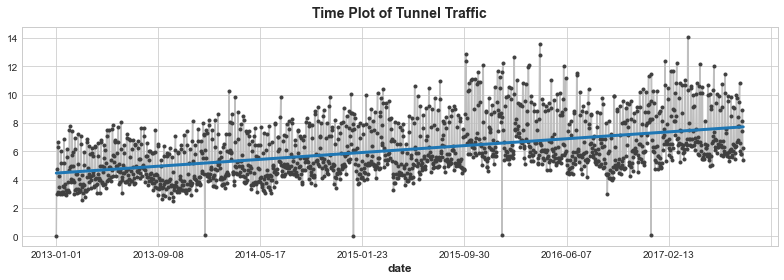

In [13]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic')
plt.show()


### Seaborn Example

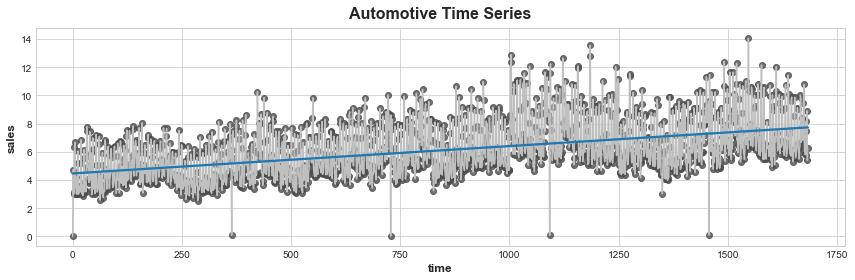

In [14]:
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
fig, axe = plt.subplots()
axe.plot('time', 'sales', data=automotive_sum, color='0.75')
axe.set_title('Automotive Time Series')
axe = sns.regplot(x='time', y='sales', data=automotive_sum, ci=None, scatter_kws=dict(color='0.3'))
plt.show()

## Check the Serial Dependence
    - IOW, check if the sales of the automobile in the preivous day have any affects on the sales the day after

In [15]:


# Use lag function to shift data
automotive_sum['sales_lag'] = automotive_sum['sales'].shift(1)

automotive_sum.head()

,sales,time,sales_lag
date,,,
2013-01-01,0.000000,0,NaN
2013-01-02,4.722222,1,0.000000
2013-01-03,2.981481,2,4.722222
2013-01-04,3.129630,3,2.981481
2013-01-05,6.333333,4,3.129630


Text(0.5, 1.0, 'Automotive Sales Serial Dependence')

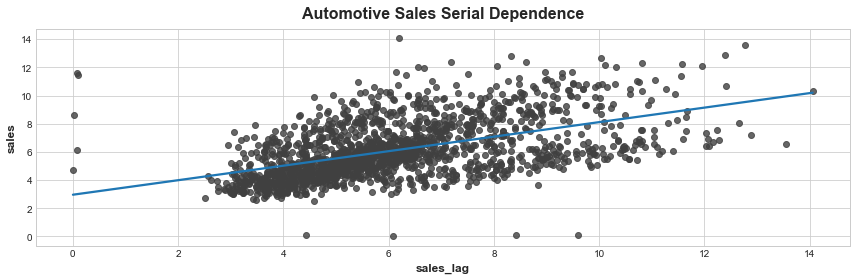

In [16]:
fig, axe = plt.subplots()
axe = sns.regplot(x = 'sales_lag', y = 'sales', data = automotive_sum, ci = None, scatter_kws=dict(color='0.25'))
axe.set_title('Automotive Sales Serial Dependence')


Notice that sales from previous day is positively correlated with the sales occuring the day after. 